In [1]:
# =========================================================
# 1. IMPORT LIBRARIES
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry

# Make plots a bit bigger by default
plt.rcParams['figure.figsize'] = (8, 4)


In [2]:
import os
os.makedirs("images", exist_ok=True)


In [3]:
# =========================================================
# 2. LOAD DATA
#    - Read CSV (Kaggle "Online Retail" dataset)
#    - Use correct encoding to avoid UnicodeDecodeError
# =========================================================
data = pd.read_csv(
    "Online Retail Data Set.csv",
    usecols=['InvoiceDate', 'Quantity', 'CustomerID', 'Country', 'UnitPrice'],
    encoding='ISO-8859-1'
)

df = pd.DataFrame(data)
print("Raw shape:", df.shape)
df.head()


Raw shape: (541909, 5)


,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# =========================================================
# 3. BASIC CLEANING
#    - Drop missing CustomerID
#    - Remove negative quantities (returns)
#    - Convert InvoiceDate to datetime and drop bad rows
# =========================================================
df = df.dropna(subset=['CustomerID'])        # keep only customers with ID
df = df[df['Quantity'] > 0]                 # remove returns / negative qty

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df.dropna(subset=['InvoiceDate'])      # remove rows where date failed

print("After cleaning:", df.shape)
df.head()


After cleaning: (168649, 5)


,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# =========================================================
# 4. FEATURE ENGINEERING
#    - Add 'sales' = Quantity * UnitPrice
#    - Extract hour, day_name, date, month
# =========================================================
df['sales'] = df['Quantity'] * df['UnitPrice']

# Time features
df['hour'] = df['InvoiceDate'].dt.hour
df['day_name'] = df['InvoiceDate'].dt.day_name()
df['date'] = df['InvoiceDate'].dt.date
df['month'] = df['InvoiceDate'].dt.to_period('M')

df[['InvoiceDate', 'day_name', 'hour', 'sales']].head()


,InvoiceDate,day_name,hour,sales
0,2010-01-12 08:26:00,Tuesday,8,15.30
1,2010-01-12 08:26:00,Tuesday,8,20.34
2,2010-01-12 08:26:00,Tuesday,8,22.00
3,2010-01-12 08:26:00,Tuesday,8,20.34
4,2010-01-12 08:26:00,Tuesday,8,20.34


In [6]:
# =========================================================
# 5. CUSTOMER-LEVEL STATS
#    - Total sales per customer
#    - Number of transaction days (unique InvoiceDate)
#    - Plot top 10 customers
# =========================================================
customer_stats = df.groupby('CustomerID').agg(
    total_sales=('sales', 'sum'),
    transactions=('InvoiceDate', 'nunique')
).reset_index()

customer_stats = customer_stats.sort_values('total_sales', ascending=False)

print("Top 10 customers:")
customer_stats.head(10)



Top 10 customers:


,CustomerID,total_sales,transactions
2075,16446.0,168469.60,1
2904,18102.0,135953.04,27
1196,14646.0,87617.39,28
1328,14911.0,59175.70,74
2608,17511.0,49108.16,15
1872,16029.0,48851.67,32
38,12415.0,44582.79,10
1420,15098.0,39916.50,3
926,14156.0,37347.95,24
2189,16684.0,36992.90,7


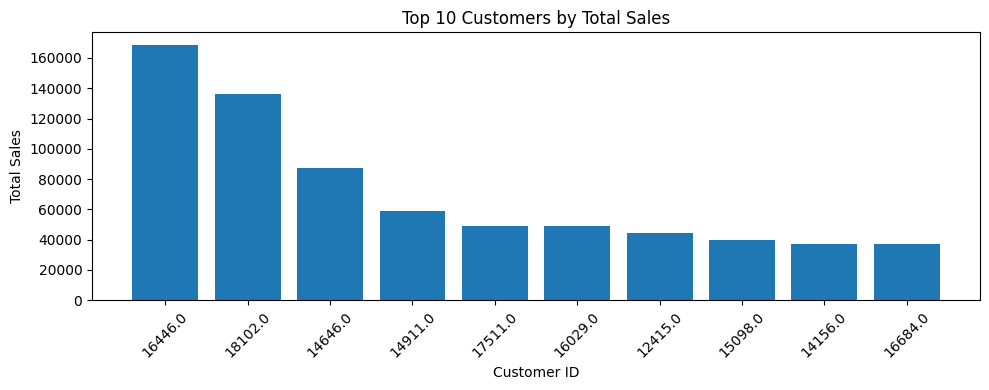

In [13]:
## Bar plot of top 10 customers by sales
top_n = 10
top_customers = customer_stats.head(top_n)

plt.figure(figsize=(10, 4))
plt.bar(top_customers['CustomerID'].astype(str), top_customers['total_sales'])
plt.xlabel("Customer ID")
plt.ylabel("Total Sales")
plt.title(f"Top {top_n} Customers by Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()

# ✅ save image
plt.savefig("images/top_customers_by_sales.png", dpi=300, bbox_inches="tight")

plt.show()



In [8]:
# =========================================================
# 6. GLOBAL DAILY ACTIVITY HEATMAP (ALL COUNTRIES)
#    - Group by day_name + hour
#    - Create pivot table (rows = days, cols = hours)
#    - Plot Reds heatmap
# =========================================================
grouped = df.groupby(['day_name', 'hour']).size().reset_index(name='count')

# Fix day order: Monday -> Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped['day_name'] = pd.Categorical(grouped['day_name'], categories=day_order, ordered=True)

pivot = grouped.pivot(index='day_name', columns='hour', values='count').fillna(0)
pivot



hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_name,,,,,,,,,,,,,,
Monday,22.0,503.0,1619.0,2212.0,2234.0,4320.0,3029.0,2549.0,2017.0,1228.0,837.0,170.0,244.0,156.0
Tuesday,16.0,763.0,1648.0,2791.0,3967.0,5557.0,4075.0,3421.0,2908.0,1474.0,740.0,149.0,279.0,73.0
Wednesday,26.0,242.0,681.0,1686.0,2023.0,3283.0,3050.0,2276.0,2226.0,1101.0,609.0,203.0,292.0,0.0
Thursday,49.0,662.0,1871.0,2191.0,2857.0,5055.0,3405.0,3929.0,2706.0,1603.0,1127.0,225.0,95.0,3.0
Friday,10.0,483.0,1315.0,2604.0,3234.0,5195.0,4005.0,4069.0,3737.0,2189.0,915.0,532.0,418.0,56.0
Saturday,42.0,381.0,998.0,2439.0,2980.0,4986.0,3818.0,3506.0,2014.0,1229.0,669.0,0.0,0.0,0.0
Sunday,15.0,789.0,1517.0,2604.0,3184.0,3915.0,3350.0,3272.0,2252.0,1634.0,1344.0,96.0,303.0,73.0


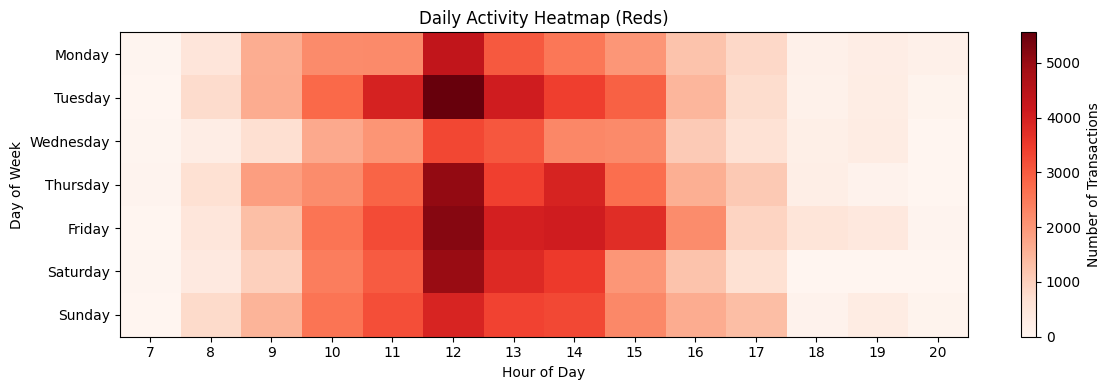

In [9]:
# Heatmap (Reds)
plt.figure(figsize=(12, 4))

plt.imshow(pivot.values, aspect='auto', interpolation='nearest', cmap='Reds')
plt.colorbar(label='Number of Transactions')

plt.xticks(
    ticks=range(len(pivot.columns)),
    labels=pivot.columns
)
plt.yticks(
    ticks=range(len(pivot.index)),
    labels=pivot.index
)

plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Daily Activity Heatmap (Reds)')
plt.tight_layout()

# ✅ save image
plt.savefig("images/overall_activity_heatmap.png", dpi=300, bbox_inches="tight")

plt.show()


In [10]:
# =========================================================
# 7. PEAK / OFF HOURS AND BUSIEST / QUIETEST DAY
# =========================================================
# Total transactions per hour
hour_totals = pivot.sum(axis=0)
peak_hour = hour_totals.idxmax()
off_hour = hour_totals.idxmin()

print("Peak hour:", peak_hour)
print("Off hour:", off_hour)
print(hour_totals)

# Total transactions per day
day_totals = pivot.sum(axis=1)
busiest_day = day_totals.idxmax()
quietest_day = day_totals.idxmin()

print("Busiest Day:", busiest_day)
print("Quietest Day:", quietest_day)
day_totals





Peak hour: 12
Off hour: 7
hour
7       180.0
8      3823.0
9      9649.0
10    16527.0
11    20479.0
12    32311.0
13    24732.0
14    23022.0
15    17860.0
16    10458.0
17     6241.0
18     1375.0
19     1631.0
20      361.0
dtype: float64
Busiest Day: Friday
Quietest Day: Wednesday


day_name
Monday       21140.0
Tuesday      27861.0
Wednesday    17698.0
Thursday     25778.0
Friday       28762.0
Saturday     23062.0
Sunday       24348.0
dtype: float64

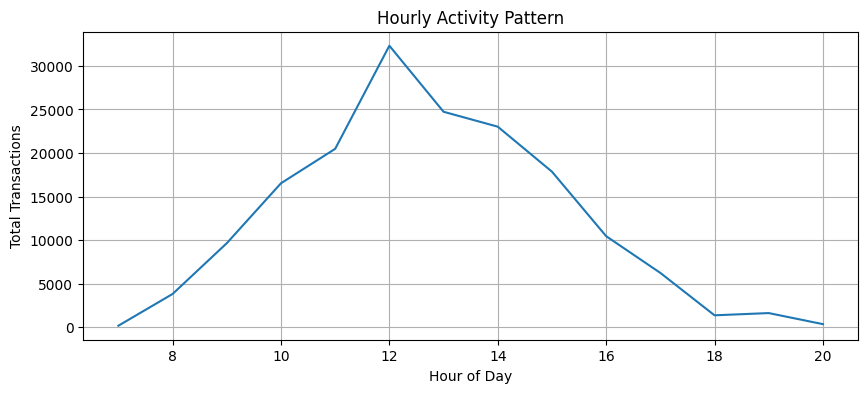

In [16]:
# Hourly pattern line plot
plt.figure(figsize=(10, 4))
plt.plot(hour_totals.index, hour_totals.values)
plt.xlabel("Hour of Day")
plt.ylabel("Total Transactions")
plt.title("Hourly Activity Pattern")
plt.grid(True)

# ✅ save image
plt.savefig("images/hourly_activity_pattern.png", dpi=300, bbox_inches="tight")

plt.show()


In [37]:
# =========================================================
# 8. SIMPLE ANOMALY DETECTION WITH Z-SCORE
#    - Flatten heatmap values
#    - Flag cells where |z| > 2 as anomalies
# =========================================================
values = pivot.values.flatten()
mean = values.mean()
std = values.std()

z_scores = (values - mean) / std
threshold = 2  # |z| > 2 => anomaly

rows, cols = pivot.shape

print("Anomalous time slots (|z| > 2):")
for idx, z in enumerate(z_scores):
    if abs(z) > threshold:
        r = idx // cols
        c = idx % cols
        print(
            f"  {pivot.index[r]}, hour {pivot.columns[c]}: "
            f"{pivot.values[r, c]} transactions (z={z:.2f})"
        )


Anomalous time slots (|z| > 2):
  Tuesday, hour 12: 5557.0 transactions (z=2.56)
  Thursday, hour 12: 5055.0 transactions (z=2.23)
  Friday, hour 12: 5195.0 transactions (z=2.32)
  Saturday, hour 12: 4986.0 transactions (z=2.18)


In [38]:
# =========================================================
# 9. COUNTRY DISTRIBUTION
#    - How many rows per country?
#    - List available countries
# =========================================================
country_counts = df['Country'].value_counts()
print("Top 10 countries by transaction count:")
print(country_counts.head(10))

country_list = df['Country'].unique()
print("\nAvailable countries:", country_list)



Top 10 countries by transaction count:
Country
United Kingdom    150500
France              3914
Germany             3718
EIRE                2802
Spain                990
Belgium              848
Switzerland          833
Netherlands          809
Portugal             754
Norway               469
Name: count, dtype: int64

Available countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Sweden'
 'Cyprus' 'Austria' 'Finland' 'Greece' 'Singapore' 'Unspecified' 'Canada'
 'Bahrain' 'European Community' 'Malta' 'United Arab Emirates' 'Israel'
 'Czech Republic' 'USA']


Rows for United Kingdom: 150500
hour         7      8       9       10      11      12      13      14  \
day_name                                                                 
Monday     22.0  397.0  1215.0  1596.0  1997.0  3899.0  2685.0  2300.0   
Tuesday    12.0  478.0  1192.0  2185.0  3785.0  5152.0  3586.0  3250.0   
Wednesday  26.0  181.0   538.0  1494.0  1766.0  3049.0  2810.0  2104.0   
Thursday   49.0  662.0  1557.0  1878.0  2707.0  4598.0  3086.0  3368.0   
Friday     10.0  381.0  1086.0  2256.0  2790.0  4894.0  3549.0  3343.0   
Saturday   42.0  246.0   762.0  1813.0  2766.0  4746.0  3401.0  3087.0   
Sunday      0.0  515.0  1275.0  2349.0  2980.0  3641.0  3211.0  2983.0   

hour           15      16      17     18     19     20  
day_name                                                
Monday     1870.0  1102.0   833.0  170.0  167.0  156.0  
Tuesday    2589.0  1165.0   593.0  149.0  231.0   73.0  
Wednesday  2123.0  1040.0   564.0  203.0  292.0    0.0  
Thursday   2547.

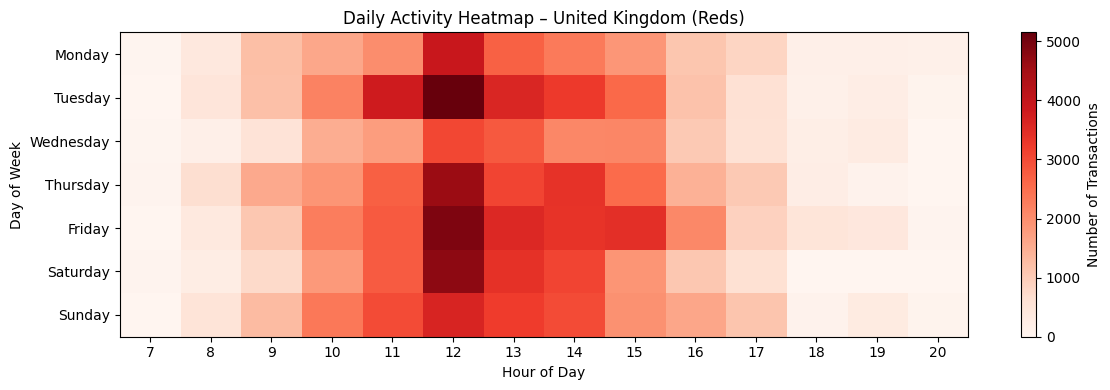

In [15]:
# =========================================================
# 10. COUNTRY-SPECIFIC HEATMAP (CHANGE COUNTRY NAME)
# =========================================================
country_name = "United Kingdom"   # 👈 change this value to test other countries
df_country = df[df['Country'] == country_name].copy()

print(f"Rows for {country_name}:", len(df_country))

if df_country.empty:
    print(f"No data available for country: {country_name}")
else:
    # Extract time features
    df_country['hour'] = df_country['InvoiceDate'].dt.hour
    df_country['day_name'] = df_country['InvoiceDate'].dt.day_name()

    # Group by day + hour
    grouped_country = (
        df_country
        .groupby(['day_name', 'hour'])
        .size()
        .reset_index(name='count')
    )

    # Ensure same day order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    grouped_country['day_name'] = pd.Categorical(
        grouped_country['day_name'],
        categories=day_order,
        ordered=True
    )

    # Pivot and reindex to force full Mon–Sun rows
    pivot_country = grouped_country.pivot(
        index='day_name',
        columns='hour',
        values='count'
    )
    pivot_country = pivot_country.reindex(day_order).fillna(0)

    print(pivot_country)

    # Plot heatmap (Reds)
    plt.figure(figsize=(12, 4))
    plt.imshow(pivot_country.values, aspect='auto', interpolation='nearest', cmap='Reds')
    plt.colorbar(label='Number of Transactions')

    plt.xticks(
        ticks=range(len(pivot_country.columns)),
        labels=pivot_country.columns
    )
    plt.yticks(
        ticks=range(len(pivot_country.index)),
        labels=pivot_country.index
    )

    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.title(f'Daily Activity Heatmap – {country_name} (Reds)')
    plt.tight_layout()

# ✅ change file name per country
plt.savefig(f"images/country_heatmap_{country_name.replace(' ', '_')}.png",
            dpi=300, bbox_inches="tight")

plt.show()




In [20]:
# =========================================================
# 11. WORLD MAP – TRANSACTION VOLUME BY COUNTRY
#    - Use pycountry to get ISO3 codes
#    - Plot plotly choropleth map
# =========================================================
# Aggregate by country
country_txn = df.groupby('Country')['sales'].sum().reset_index(name='transactions')

def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

country_txn['iso3'] = country_txn['Country'].apply(get_iso3)

country_txn.head()


,Country,transactions,iso3
0,Australia,49209.71,AUS
1,Austria,2999.69,AUT
2,Bahrain,459.40,BHR
3,Belgium,16942.55,BEL
4,Canada,1751.88,CAN


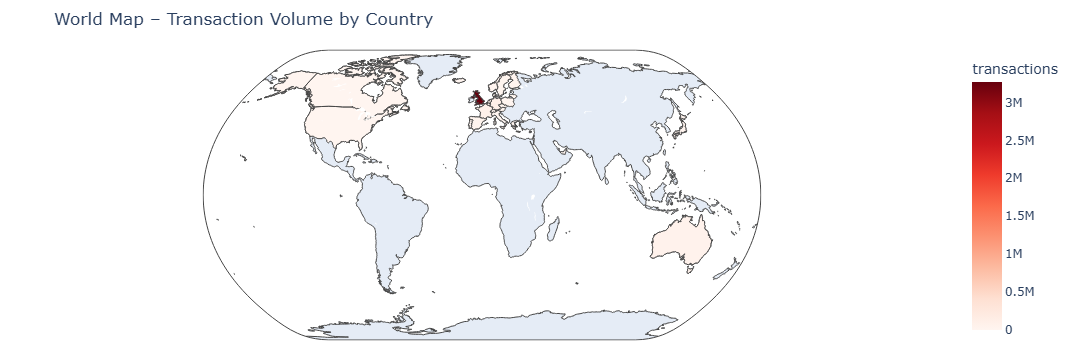

In [23]:
# Plot world map (works best in Jupyter Notebook/JupyterLab)
import plotly.express as px
import plotly.io as pio

fig = px.choropleth(
    country_txn,
    locations="iso3",
    color="transactions",
    color_continuous_scale="Reds",
    title="World Map – Transaction Volume by Country",
    projection="natural earth"
)

fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20)
)

# ✅ save as image
pio.write_image(fig, "images/world_map_transactions.png", scale=2)  # scale=2 for higher resolution

# Optional: also show in notebook (if interactive works)
fig.show()



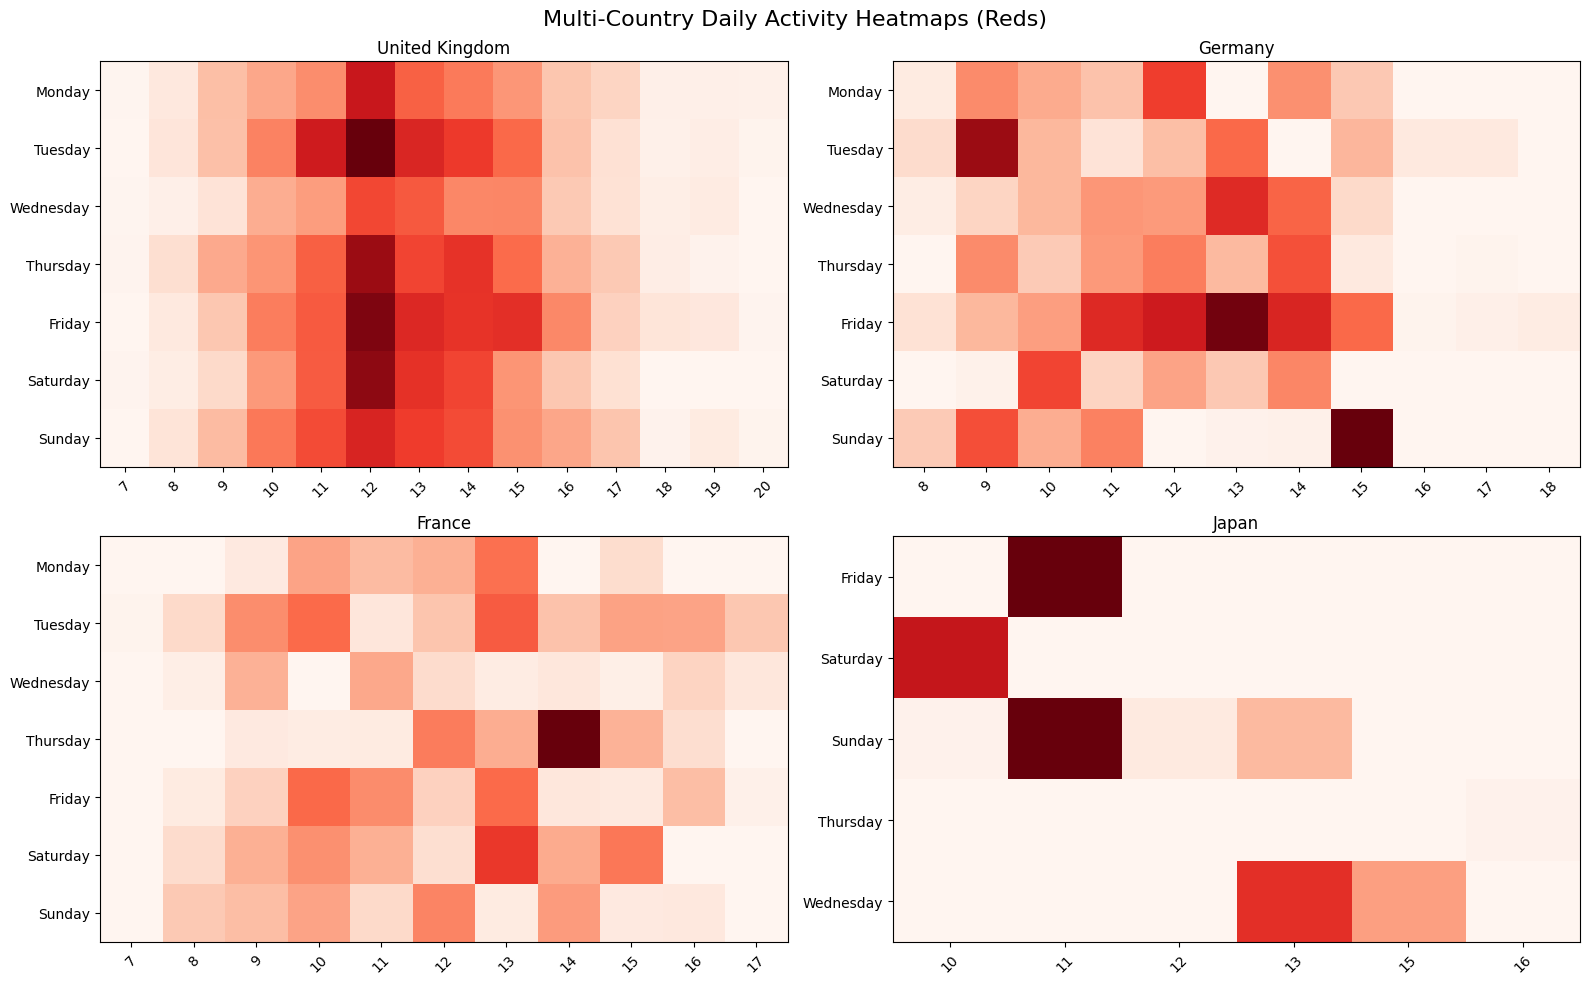

In [42]:
# =========================================================
# 12. MULTI-COUNTRY COMPARISON HEATMAPS (SUBPLOTS)
# =========================================================
countries = ["United Kingdom", "Germany", "France", "Japan"]

plt.figure(figsize=(16, 10))

for i, country in enumerate(countries):
    df_c = df[df['Country'] == country].copy()
    if df_c.empty:
        continue

    df_c['hour'] = df_c['InvoiceDate'].dt.hour
    df_c['day_name'] = df_c['InvoiceDate'].dt.day_name()

    grouped_c = df_c.groupby(['day_name', 'hour']).size().reset_index(name='count')

    grouped_c['day_name'] = pd.Categorical(grouped_c['day_name'], categories=day_order, ordered=True)
    pivot_c = grouped_c.pivot(index='day_name', columns='hour', values='count').fillna(0)

    plt.subplot(2, 2, i + 1)
    plt.imshow(pivot_c.values, cmap="Reds", aspect='auto')
    plt.title(country)
    plt.xticks(
        ticks=range(len(pivot_c.columns)),
        labels=pivot_c.columns,
        rotation=45
    )
    plt.yticks(
        ticks=range(len(pivot_c.index)),
        labels=pivot_c.index
    )

plt.suptitle("Multi-Country Daily Activity Heatmaps (Reds)", fontsize=16)
plt.tight_layout()
plt.show()


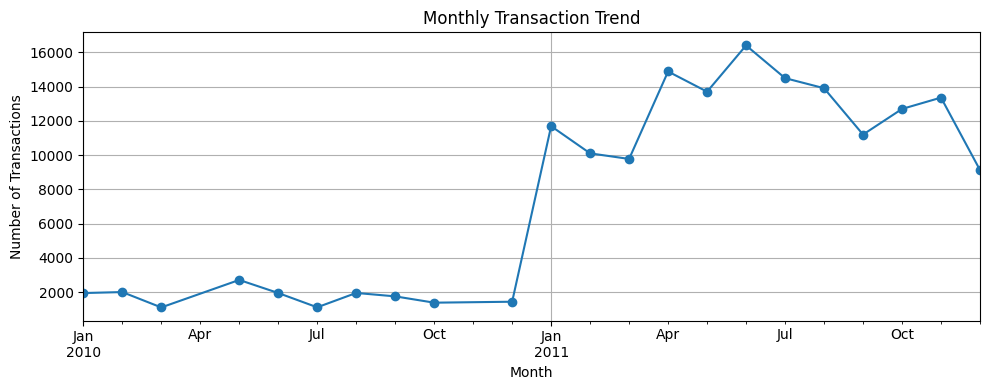

In [43]:
# =========================================================
# 13. MONTHLY TREND – HOW ACTIVITY CHANGES OVER TIME
# =========================================================
monthly_counts = df.groupby('month').size()

plt.figure(figsize=(10, 4))
monthly_counts.plot(kind='line', marker='o')
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.title("Monthly Transaction Trend")
plt.grid(True)
plt.tight_layout()
plt.show()
